In [3]:
import io
import os
import unicodedata
import string
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [4]:
ALL_LETTERS = string.ascii_letters + ".,;"
N_LETTERS = len(ALL_LETTERS)

In [5]:
def unicode_to_ascii(s):
    return''.join(
        c for c in unicodedata.normalize('NFD' , s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
def load_data():
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    def read_lines(file_name):
        lines = io.open(file_name, encoding ='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for file_name in find_files('/content/drive/MyDrive/Data sets(GP)/names/*.txt'):
        category = os.path.splitext(os.path.basename(file_name))[0]
        all_categories.append(category)

        lines = read_lines(file_name)
        category_lines[category] = lines

    return category_lines, all_categories

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

In [10]:
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

In [11]:
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1,N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


In [12]:
def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a)-1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = line_to_tensor(line)

    return category, line, category_tensor, line_tensor



In [13]:
print(ALL_LETTERS)
print(unicode_to_ascii('Ślusarski'))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;
Slusarski


In [14]:
category_lines, all_categories = load_data()

In [15]:
print(all_categories)

['Chinese', 'Dutch', 'Arabic', 'English', 'French', 'Czech', 'Irish', 'Spanish', 'Portuguese', 'Polish', 'Japanese', 'Italian', 'Scottish', 'German', 'Russian', 'Greek', 'Vietnamese', 'Korean']


In [16]:
for category, lines in category_lines.items():
    print(f"{category}: {len(lines)} lines")


Chinese: 268 lines
Dutch: 297 lines
Arabic: 2000 lines
English: 3668 lines
French: 277 lines
Czech: 519 lines
Irish: 232 lines
Spanish: 298 lines
Portuguese: 74 lines
Polish: 139 lines
Japanese: 991 lines
Italian: 709 lines
Scottish: 100 lines
German: 724 lines
Russian: 9408 lines
Greek: 203 lines
Vietnamese: 73 lines
Korean: 94 lines


In [17]:
print(category_lines['Italian'][:5])


['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(hidden_size + input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size + input_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input_tensor, hidden_tensor):

        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)







In [19]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
print(n_categories)

18


In [20]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [21]:
input_tensor = line_to_tensor('Albret')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [22]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [23]:
print(category_from_output(output))

English


In [24]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate )

In [25]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output,category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

999 0.19980000000000003 2.6894 Panayiotopoulos / Greek CORRECT
1999 0.3998 2.5553 Pasternack / Polish CORRECT
2999 0.5998 2.9732 Swango / Portuguese WRONG(German)
3999 0.7998 2.9005 Hunter / German WRONG(Scottish)
4999 0.9998 2.2243 Bandini / Italian CORRECT
5999 1.1998 1.7128 Rao / Chinese CORRECT
6999 1.3998 1.4837 Shin / Korean CORRECT
7999 1.5997999999999999 2.7825 Arihyoshi / Polish WRONG(Japanese)
8999 1.7998 2.5918 OCallaghann / Scottish WRONG(Irish)
9999 1.9997999999999998 2.4923 Vega / Chinese WRONG(Spanish)
10999 2.1998 2.9919 Scott / French WRONG(Scottish)
11999 2.3998 1.1841 Pavoni / Italian CORRECT
12999 2.5998 0.4947 Sniegowski / Polish CORRECT
13999 2.7998 2.3451 Aggi / Chinese WRONG(Italian)
14999 2.9998 2.9909 Godwin / Irish WRONG(English)
15999 3.1997999999999998 2.7336 Tillens / Dutch WRONG(German)
16999 3.3998 4.0974 Daal / Vietnamese WRONG(Dutch)
17999 3.5998 2.1747 Sarkis / Greek WRONG(Arabic)
18999 3.7998 0.5705 Paterson / Scottish CORRECT
19999 3.9998 1.4154 Ank

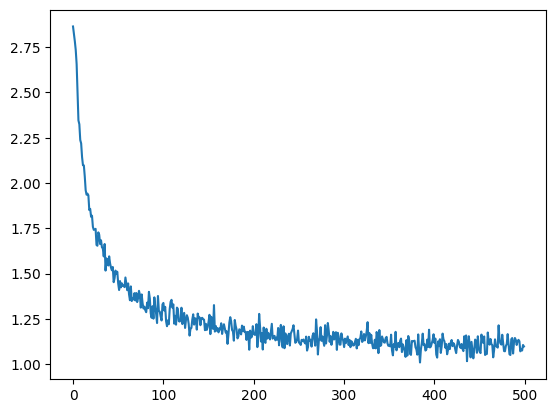

In [26]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 500000
for i in range(n_iters):

    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output, loss = train(line_tensor, category_tensor)

    current_loss += loss

    if (i+1)%plot_steps == 0:
        all_losses.append(current_loss / plot_steps )
        current_loss = 0

    if (i+1)%plot_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT"  if guess == category else f"WRONG({category})"
        print(f"{i} {i/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

plt.figure()
plt.plot(all_losses)
plt.show()


In [29]:
def predict(input_line):
    print(f"\n>{input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output,hidden = rnn(line_tensor[i], hidden)
            guess = category_from_output(output)

        print(guess)


In [ ]:
while True:
    sentence = input ("Input : ")
    if sentence == "quit":
        break
    predict(sentence)

Input : Dina

>Dina
Vietnamese
Input : Gorge

>Gorge
French
Input : Aya

>Aya
Korean
Input : Ahmed

>Ahmed
Arabic
Input : Malek

>Malek
Czech
